In [44]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i for i, s in enumerate(('.', *chars))}
itos = {i: s for s, i in stoi.items()}
num_classes = len(stoi)

print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [stoi['.']] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]

    return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)


n1, n2 = int(len(words)*0.8), int(len(words)*0.9)

random.shuffle(words)

X_train, Y_train = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

In [5]:
Y_train.shape, Y_dev.shape, Y_test.shape

(TensorShape([182521]), TensorShape([22779]), TensorShape([22846]))

In [6]:
embedding_size = 10
hidden_layer_size = 300

C = tf.Variable(tf.random.normal((num_classes, embedding_size)), name='C')
W1 = tf.Variable(tf.random.normal((embedding_size * block_size, hidden_layer_size)), name='W1')
b1 = tf.Variable(tf.zeros(hidden_layer_size, dtype=tf.float32), name='b1')
W2 = tf.Variable(tf.random.normal((hidden_layer_size, num_classes)), name='W2')
b2 = tf.Variable(tf.zeros(num_classes, dtype=tf.float32), name='b2')

parameters = [C, W1, b1, W2, b2]

def eval_logits(X):
    emb = tf.gather(C, X)
    h = tf.math.tanh(tf.reshape(emb, (-1, embedding_size * block_size)) @ W1 + b1)
    return h @ W2 + b2

def eval_loss(X, Y):
    logits = eval_logits(X)
    loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y, logits, from_logits=True))
    return loss


In [7]:
# GPU is using FP16 for some reason. 
# with tf.device('/CPU:0'):
#     print(tf.one_hot([5], num_classes) @ C)
# print(tf.one_hot([5], num_classes) @ C)
# print(tf.cast(tf.cast(C[5], dtype=tf.float16), dtype=tf.float32))

In [8]:
step_loss = []


In [29]:
learning_rate = 0.1
for _ in range(10000):
    
    batch_ix = tf.random.uniform(shape=(64,), minval=0, maxval=X_train.shape[0], dtype=tf.int32)
    X_batch = tf.gather(X_train, batch_ix)
    Y_batch = tf.gather(Y_train, batch_ix)

    with tf.GradientTape() as tape:
        # emb = tf.gather(C, X_batch)
        # h = tf.math.tanh(tf.reshape(emb, (-1, embedding_size * block_size)) @ W1 + b1)
        # logits = h @ W2 + b2
        # counts = tf.math.exp(logits)
        # prob = counts / tf.reduce_sum(counts, axis=1, keepdims=True)
        # prob_indexer = tf.stack([tf.range(Y.shape[0]), Y], axis=1)
        # loss = -tf.math.reduce_mean(tf.math.log(tf.gather_nd(prob, prob_indexer)))
        # loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y_batch, logits, from_logits=True))
        loss = eval_loss(X_batch, Y_batch)
        #print(loss.numpy())

    for p, dl_dp in zip(parameters, tape.gradient(loss, parameters)):
        # tape.gradient(loss, C) returns IndexedSlices with:
        #   indicies = rows indicies of the embedding lookup table C
        #   values = tensor of gradients for rows in C for  indicies
        # Indicies can contain duplicates so we need to sum the gradients for each index together.
        # This can be done with tf.convert_to_tensor (see example below)
        p.assign_sub(learning_rate*tf.convert_to_tensor(dl_dp))

    step_loss.append(loss)


print(f'batch = {loss.numpy()}, train = {eval_loss(X_train, Y_train).numpy()}, dev = {eval_loss(X_dev, Y_dev).numpy()}')

batch = 2.3355822563171387, train = 2.2505645751953125, dev = 2.269709825515747


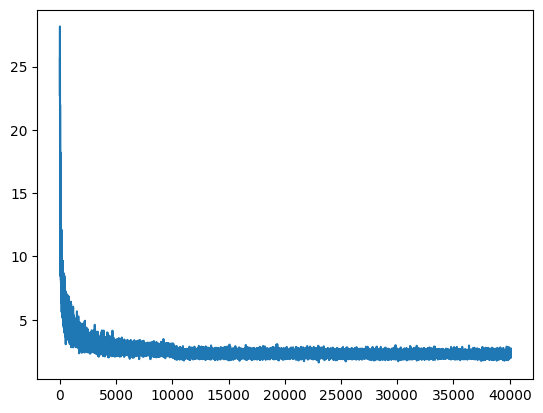

In [30]:
plt.plot(step_loss)

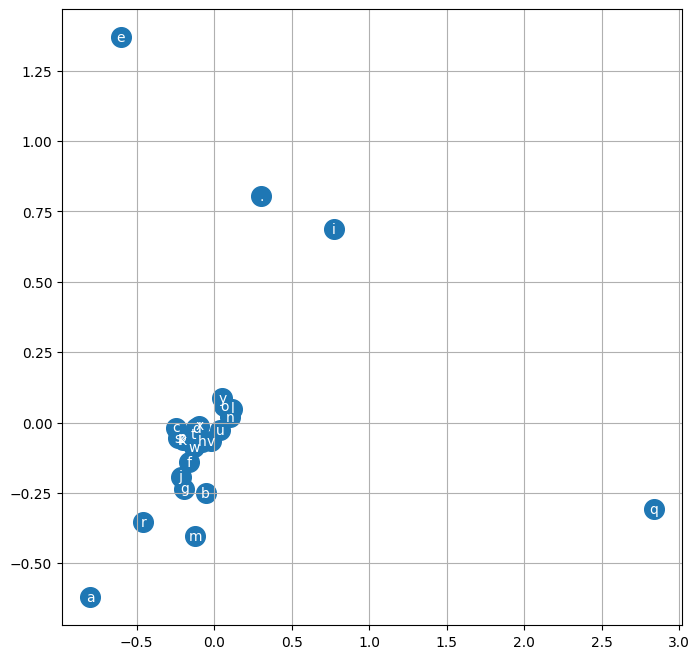

In [31]:
emb_2d = PCA(n_components=2).fit_transform(C.numpy())

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=200)
for i in range(C.shape[0]):
    plt.text(emb_2d[i,0], emb_2d[i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [109]:
# batch generate examples

gen_batch_size = 10
gen_target = 20

gen_count = 0
start_context = tf.zeros((gen_batch_size, block_size), dtype=tf.int32)
context = start_context
out = [[] for _ in range(gen_batch_size)]

while gen_count < gen_target:
    logits = eval_logits(context)
    next_one_hot = tfp.distributions.Multinomial(1, logits=logits).sample()
    next_ix = tf.argmax(next_one_hot, axis=1, output_type=tf.int32)

    reset = []
    for con_i, (o, i) in enumerate(zip(out, next_ix)):
        o.append(itos[i.numpy()])
        if i == 0:
            print(''.join(o))
            o.clear()
            gen_count += 1
            reset.append([con_i])


    context = tf.concat([context[:, 1:], tf.reshape(next_ix, (-1, 1))], axis=1)

    # context might have rows like [5, 10, 0] which will cause the nn to produce
    # nonsence, 
    if len(reset) > 0:
        context = tf.tensor_scatter_nd_update(
            context,
            reset, 
            start_context[:len(reset), :]
        )



zan.
zen.
lina.
brey.
daler.
rocel.
damir.
afrida.
aya.
gean.
benry.
abd.
cla.
sourazariah.
aroiyah.
caiveshan.
yokoriyah.
laymn.
kupabrigbesreen.
fusny.
toriye.


In [33]:
# convert_to_tensor(IndexedSlices) example

# sparse_tensor = tf.IndexedSlices(
#     values=[1, 1, 1, 1, 1, 1 ,1], 
#     indices=[0, 1, 1, 1, 1, 1, 4], 
#     dense_shape=(10,)
# )

# print(tf.convert_to_tensor(sparse_tensor))